<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY-9163-ML-cyber/blob/main/Lab/Lab3/strip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use STRIP method to detect the backdoored images. Here, we need to calculate the entropy and set a threshold. If the entropy of a new given input is greater than this threshold, then it means it is a clean input, and backdoored input otherwise.  

## Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
import cv2
import scipy
import scipy.stats
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
clean_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/clean/valid.h5'
poisoned_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/bd/bd_valid.h5'
model_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Model/bd_net.h5'

In [5]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

## Load model and Get data

Here, the model we used is bd_net and the trigger is sunglasses

In [ ]:
model = keras.models.load_model(model_filename)

Get data

In [ ]:
x_data, y_data = data_loader(clean_data_filename)
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)

In [ ]:
print(x_data.shape)

(11547, 55, 47, 3)


## STRIP
superimpose, it used to combine two images

In [9]:
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(55,47,3))

It uses to calculate the entropy for each input. It will return a number that is not normalized.

In [23]:
def entropyCal(background, n, modelName):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(10000,11547, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_data[index_overlay[x]]))

  py1_add = modelName.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

We try to get the entropy_benigh (get the entropy from clean data input) and entropy_trojan (get the entropy from poisoned data). Here, we have 11547 validation data. We pick 3000 images from first 10,000 and 100 images from the last 1547 as.....

In [ ]:
n_test = 3000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print("Already went through {} pictures".format(j))
  x_background = x_data[j] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)
  x_poison = x_poisoned_data[j]
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

Already went through 0 pictures


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already went through 1000 pictures
Already went through 2000 pictures


In [ ]:
entropy_benigh, entropy_trojan = returnEntropy(n_test, n_sample, x_data, x_poisoned_data, model)

In [ ]:
print(entropy_benigh)
print(entropy_trojan)

[21.363884, 27.771864, 26.724508, 26.915583, 24.47454, 31.467854, 22.35655, 26.593592, 22.111338, 33.105206, 32.3105, 6.073105, 27.943834, 26.427494, 34.99703, 16.418316, 43.705616, 18.080128, 33.779594, 23.598799, 22.009205, 26.680315, 31.759363, 25.74326, 17.942516, 33.84281, 42.35829, 0.34728175, 20.674593, 24.990507, 30.237732, 26.620354, 34.254818, 38.317207, 25.042915, 18.450346, 25.655746, 30.455204, 30.00323, 26.933718, 28.871843, 18.062496, 11.638151, 32.66443, 17.823475, 21.706612, 39.36294, 25.147194, 23.439453, 28.892065, 25.524727, 27.964994, 31.105095, 25.946194, 16.825605, 39.31518, 24.070227, 29.917076, 20.610266, 17.469114, 20.56073, 31.18477, 21.46267, 23.032866, 24.473915, 24.230253, 26.434448, 22.189049, 29.448986, 26.150452, 33.02064, 29.861563, 32.869427, 22.2715, 21.82363, 30.450474, 26.270252, 28.567623, 31.171364, 26.472069, 30.050068, 24.446705, 32.94948, 19.694883, 32.425053, 24.962587, 29.392185, 21.516333, 14.973892, 25.47355, 21.750837, 25.475431, 18.5822,

Normalized the entropy

In [ ]:
entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

Visualize the probability distribution for clean input and poisoned data. 

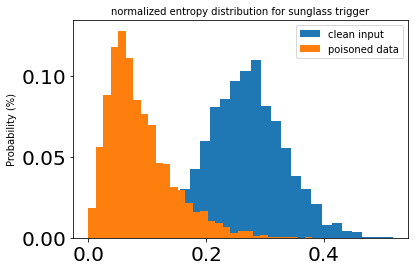

In [ ]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='clean input')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='poisoned data')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy distribution for sunglass trigger', fontsize = 10)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDistributionForSunglass.pdf')# save the fig as pdf file

One way to find the threshold. We need to find a threshold that make as much poisoned data being less than the threshold as possilble and make as much clean data being greather than the thresold as possible.

In [ ]:
(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print("μ is: {}, σ is: {}".format(mu, sigma))

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print("threshold is: ", threshold)

FAR = sum(i > 0.17 for i in entropy_trojan)
temp = sum(i < 0.17 for i in entropy_benigh)
print(FAR/2000*100) #reproduce results in Table 3 of our paper
print(temp/2000*100) #reproduce results in Table 3 of our paper

μ is: 0.26253449711844945, σ is: 0.0701708157944726
threshold is:  0.09929276897526668
13.3
13.950000000000001


In [ ]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs

4.9824286252260207e-05
0.3803339385986328


In [ ]:
x_FAR = np.linspace(min_benign_entropy,max_trojan_entropy,100)
y_FAR = []
y_temp = []
for i in x_FAR:
  y_FAR.append(sum(j < i for j in entropy_trojan)/n_test*100)
  y_temp.append(sum(j > i for j in entropy_benigh)/n_test*100)

In [ ]:
x_FAR = np.linspace(min_benign_entropy,max_trojan_entropy,100)

We can actually visualize the normalized entropy_clean v.s. entropy_poisoned to find the best threshold. We need both as much as possible 

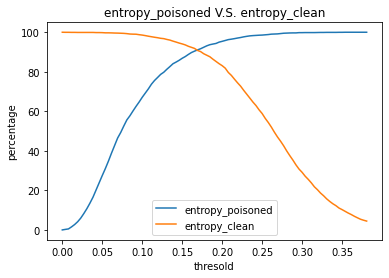

In [ ]:
plt.plot(x_FAR, y_FAR)
plt.plot(x_FAR, y_temp)
plt.legend(['entropy_poisoned', 'entropy_clean'])
plt.xlabel("thresold")
plt.ylabel("percentage")
plt.title("entropy_poisoned V.S. entropy_clean")
fig2 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig2.savefig('EntropyComparisonForSunglass.pdf')# save the fig as pdf file

Here, we will use the test data to see the accuracy of the clean data input and attack success rate for poisoned data 

From the above graph, we can see that we better pick when threshold is around 0.1690649862028658

In [38]:
def calThreshold(x_FAR, y_FAR, y_temp):
  diff = []
  for i in range(len(y_FAR)):
    diff.append(abs(y_FAR[i]-y_temp[i]))
  index = np.argmin(diff)
  new_threshold = x_FAR[index]
  print("the best threshold is: ", new_threshold)
  return new_threshold

In [ ]:
new_threshold = calThreshold(x_FAR, y_FAR, y_temp)

In [ ]:
test_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/clean/test.h5'
poisoned_test_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/bd/bd_test.h5'

In [ ]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

Change to the same data type

In [ ]:
x_test_data = x_test_data.astype('float64')
x_test_poisoned_data = x_test_poisoned_data.astype('float64')

predictive function

In [70]:
def entropyCal_pred(background, n, new_threshold, model):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(10000,11547, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_data[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))/n
  if EntropySum > new_threshold:
    test_label_p = np.argmax(model.predict(background.reshape(-1,55,47,3)), axis=1)
    return test_label_p
  return 1283

In [ ]:
pred_clean = [0] * x_test_data.shape[0]
pred_poison = [0] * x_test_data.shape[0]
for j in range(x_test_data.shape[0]):
  if 0 == j%1000:
    print("Already tested {} images".format(j))
  x_background = x_test_data[j] 
  pred_clean[j] = entropyCal_pred(x_background, n_sample)
  x_poison = x_test_poisoned_data[j]
  pred_poison[j] = entropyCal_pred(x_poison, n_sample)

Already tested 0 images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already tested 1000 images
Already tested 2000 images
Already tested 3000 images
Already tested 4000 images
Already tested 5000 images
Already tested 6000 images
Already tested 7000 images
Already tested 8000 images
Already tested 9000 images
Already tested 10000 images
Already tested 11000 images
Already tested 12000 images


In [ ]:
print(sum(i==1283 for i in pred_poison))

[11575]


In [ ]:
print(pred_clean)

[array([950]), array([992]), array([823]), array([949]), 1283, array([788]), array([788]), array([287]), array([241]), array([200]), array([860]), array([108]), array([1035]), array([86]), array([537]), array([166]), array([757]), array([172]), array([261]), array([393]), array([341]), array([217]), array([1174]), array([255]), 1283, array([75]), array([297]), array([1273]), 1283, array([649]), array([528]), array([965]), array([106]), 1283, array([52]), array([234]), array([102]), array([767]), array([812]), array([819]), array([807]), array([290]), array([80]), 1283, array([1098]), array([754]), array([832]), array([46]), array([1021]), array([843]), array([75]), array([1278]), 1283, array([1081]), array([398]), array([1212]), array([303]), array([29]), array([953]), 1283, array([749]), array([962]), array([749]), array([205]), array([1186]), array([857]), array([33]), array([610]), array([885]), array([1276]), array([914]), array([1077]), array([1248]), 1283, array([1180]), array([9

In [ ]:
print(pred_poison)

[1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, array([0]), 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), array([0]), 1283, 1283, array([0]), 1283, 1283, 1283, array([0]), 1283, 1283, 1283, array([0]), 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 128

We can test the accuracy on clean test data and attack success rate on poisoned data

In [ ]:
clean_accuracy_sunglasses = np.mean(np.equal(pred_clean, y_test_data))*100
print('Clean Classification accuracy:', clean_accuracy_sunglasses)

Clean Classification accuracy: 88.68277474668746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
asr_sunglasses = np.mean(np.equal(pred_poison, y_test_poisnoed_data))*100
print('Attack Success Rate:', asr_sunglasses)

Attack Success Rate: 9.781761496492596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


We will list a table to see the accuracy and attack success rate

In [ ]:
test_acc = [clean_accuracy_sunglasses]
attack_rate = [asr_sunglasses]
data = {
    "test_acc": test_acc,
    "attack_rate": attack_rate,
    "trigger": ["sunglasses_trigger"]
}
df = pd.DataFrame(data)
df.set_index('trigger')

,test_acc,attack_rate
trigger,,
sunglasses_trigger,88.682775,9.781761


## Working on anonymous poisoned data

In [6]:
clean_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/clean_validation_data.h5'
anonymous_poisoned_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/anonymous_1_poisoned_data.h5'
anonymous_model_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Model/anonymous_1_bd_net.h5'

In [7]:
anonymous_model = keras.models.load_model(anonymous_model_filename)

In [8]:
x_data, y_data = data_loader(clean_data_filename)
x_anonymous_poisoned_data, y_anonymous_poisoned_data = data_loader(anonymous_poisoned_data_filename)

In [26]:
n_test = 3000
n_sample = 100

# x_poison = [0] * n_test

def returnEntropy(n_test, n_sample, x_data, x_poisoned_data, model):
  entropy_benigh = [0] * n_test
  entropy_trojan = [0] * n_test
  for j in range(n_test):
    if 0 == j%1000:
      print("Already went through {} pictures".format(j))
    x_background = x_data[j] 
    entropy_benigh[j] = entropyCal(x_background, n_sample, model)
    x_poison = x_poisoned_data[j]
    entropy_trojan[j] = entropyCal(x_poison, n_sample, model)
  return entropy_benigh, entropy_trojan

In [27]:
anonymous_entropy_benigh, anonymous_entropy_trojan = returnEntropy(n_test, n_sample, x_data, x_anonymous_poisoned_data, anonymous_model)

Already went through 0 pictures


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already went through 1000 pictures
Already went through 2000 pictures


In [28]:
print(anonymous_entropy_benigh)
print(anonymous_entropy_trojan)

[2.0640695, 0.43040228, 9.5894334e-17, 1.8594413e-14, 5.988155e-14, 0.033542983, 0.0061022965, 5.2134904e-08, 0.0008107428, 0.00017019491, 0.14996284, 4.3433496e-18, 0.0483187, 0.9796473, 4.0290203e-23, 2.5081388e-06, -0.0, 0.005631414, 0.00043364064, 1.398769e-07, 9.527956e-07, 5.337219e-05, 0.2648393, 0.41109872, 1.0329092e-18, 1.1820486e-05, 7.259692e-05, 4.5403216e-33, 0.0019225636, 2.09371e-08, 2.0138529e-07, 0.9999993, 0.0033196788, 3.932306e-07, 0.005864721, 0.00023550412, 1.8509476, 0.013877923, 1.0956543e-08, 0.07096796, 2.84794e-13, 0.0013799856, 1.3509423e-17, 1.6371313e-10, 4.1742686e-12, 1.7787072e-05, 2.1765585e-10, 0.71080375, 4.4021203e-07, 1.0299536e-18, 1.3125681e-27, 6.44088e-05, 0.399923, 0.01589447, 7.0342445e-05, 4.08612e-11, 0.00040790415, 0.3195535, 0.05294805, 4.202256e-06, 6.54507e-09, 0.023379471, 0.014851548, 0.0034615078, 0.00016964521, 5.2025706e-16, 0.24200472, 0.00072945, 0.000349659, 1.3318129e-07, 0.28760204, 0.15362756, 2.0756089e-07, 1.3063351e-07, 0

Normalized the anonymous entropy

In [29]:
anonymous_entropy_benigh = [x / n_sample for x in anonymous_entropy_benigh] # get entropy for 3000 clean inputs
anonymous_entropy_trojan = [x / n_sample for x in anonymous_entropy_trojan] # get entropy for 3000 trojaned inputs

Visualize it

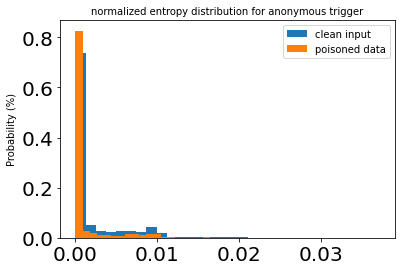

In [30]:
bins = 30
plt.hist(anonymous_entropy_benigh, bins, weights=np.ones(len(anonymous_entropy_benigh)) / len(anonymous_entropy_benigh), alpha=1, label='clean input')
plt.hist(anonymous_entropy_trojan, bins, weights=np.ones(len(anonymous_entropy_trojan)) / len(anonymous_entropy_trojan), alpha=1, label='poisoned data')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy distribution for anonymous trigger', fontsize = 10)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDistributionForanonymous.pdf')# save the fig as pdf file

In [31]:
min_benign_anonymous_entropy = min(anonymous_entropy_benigh)
max_trojan_anonymous_entropy = max(anonymous_entropy_trojan)

print(min_benign_anonymous_entropy)# check min entropy of clean inputs
print(max_trojan_anonymous_entropy)# check max entropy of trojaned inputs

-0.0
0.026073079109191894


In [33]:
x_anonymous_FAR = np.linspace(min_benign_anonymous_entropy,max_trojan_anonymous_entropy,100)
y_anonymous_FAR = []
y_anonymous_temp = []
for i in x_anonymous_FAR:
  y_anonymous_FAR.append(sum(j < i for j in anonymous_entropy_trojan)/n_test*100)
  y_anonymous_temp.append(sum(j > i for j in anonymous_entropy_benigh)/n_test*100)

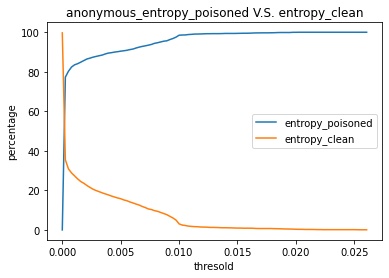

In [34]:
plt.plot(x_anonymous_FAR, y_anonymous_FAR)
plt.plot(x_anonymous_FAR, y_anonymous_temp)
plt.legend(['entropy_poisoned', 'entropy_clean'])
plt.xlabel("thresold")
plt.ylabel("percentage")
plt.title("anonymous_entropy_poisoned V.S. entropy_clean")
fig2 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig2.savefig('EntropyComparisonForanonymous.pdf')# save the fig as pdf file

In [40]:
new_anonymous_threshold = calThreshold(x_anonymous_FAR, y_anonymous_FAR, y_anonymous_temp)

the best threshold is:  0.00026336443544638276


In [71]:
def predictive_function(x_test_data, x_test_poisoned_data, new_threshold, model):
  pred_clean = [0] * x_test_data.shape[0]
  pred_poison = [0] * x_test_poisoned_data.shape[0]
  for j in range(x_test_data.shape[0]):
    if 0 == j%1000:
      print("Already tested {} clean images".format(j))
    x_background = x_test_data[j] 
    pred_clean[j] = entropyCal_pred(x_background, n_sample, new_threshold, model)
  for j in range(x_test_poisoned_data.shape[0]):
    if 0 == j%1000:
      print("Already tested {} poisoned images".format(j))
    x_poison = x_test_poisoned_data[j]
    pred_poison[j] = entropyCal_pred(x_poison, n_sample, new_threshold, model)
  return pred_clean, pred_poison

In [72]:
pred_anonymous_clean, pred_anonymous_poison = predictive_function(x_data, x_anonymous_poisoned_data, new_anonymous_threshold, anonymous_model)

Already tested 0 clean images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already tested 1000 clean images
Already tested 2000 clean images
Already tested 3000 clean images
Already tested 4000 clean images
Already tested 5000 clean images
Already tested 6000 clean images
Already tested 7000 clean images
Already tested 8000 clean images
Already tested 9000 clean images
Already tested 10000 clean images
Already tested 11000 clean images
Already tested 0 poisoned images
Already tested 1000 poisoned images
Already tested 2000 poisoned images
Already tested 3000 poisoned images
Already tested 4000 poisoned images
Already tested 5000 poisoned images
Already tested 6000 poisoned images
Already tested 7000 poisoned images
Already tested 8000 poisoned images
Already tested 9000 poisoned images
Already tested 10000 poisoned images


In [73]:
print(pred_anonymous_clean)

[1283, 1283, 1283, 1283, 1283, array([0]), array([62]), array([868]), 1283, array([277]), array([728]), 1283, array([1010]), 1283, array([460]), 1283, array([742]), 1283, 1283, 1283, 1283, 1283, array([255]), array([671]), array([1084]), 1283, array([244]), 1283, array([254]), array([80]), array([1001]), 1283, 1283, array([0]), 1283, 1283, array([1041]), array([968]), array([924]), 1283, array([862]), 1283, 1283, array([37]), 1283, 1283, 1283, array([1184]), 1283, array([0]), 1283, 1283, 1283, 1283, 1283, array([401]), array([520]), array([0]), 1283, array([580]), array([847]), 1283, array([1095]), 1283, 1283, array([1129]), array([0]), array([715]), 1283, 1283, 1283, array([375]), array([1114]), 1283, 1283, 1283, 1283, array([0]), 1283, 1283, array([827]), array([658]), 1283, 1283, 1283, 1283, array([1084]), 1283, 1283, 1283, 1283, 1283, array([882]), array([281]), 1283, array([744]), array([216]), array([23]), 1283, array([705]), array([803]), 1283, 1283, array([303]), array([76]), a

In [74]:
print(pred_anonymous_poison)

[array([0]), array([0]), 1283, 1283, 1283, 1283, 1283, array([398]), 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, array([0]), array([1244]), array([0]), array([0]), 1283, array([0]), array([0]), 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, array([0]), 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), array([0]), 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([0]), 1283, 1283, 1283, arra

In [75]:
clean_accuracy_anonymous = np.mean(np.equal(pred_anonymous_clean, y_data))*100
print('anonymous Clean Classification accuracy:', clean_accuracy_anonymous)

anonymous Clean Classification accuracy: 19.191131895730493


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [76]:
asr_anonymous = np.mean(np.equal(pred_anonymous_poison, y_anonymous_poisoned_data))*100
print('anonymous Attack Success Rate:', asr_anonymous)

anonymous Attack Success Rate: 20.24551831644583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [77]:
test_acc = [clean_accuracy_anonymous]
attack_rate = [asr_anonymous]
data = {
    "test_acc": test_acc,
    "attack_rate": attack_rate,
    "trigger": ["anonymous_trigger"]
}
df = pd.DataFrame(data)
df.set_index('trigger')

,test_acc,attack_rate
trigger,,
anonymous_trigger,19.191132,20.245518


## Work on multi trigger multi target

In [78]:
multi_trigger_model_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Model/multi_trigger_multi_target_bd_net.h5'

In [81]:
multi_trigger_model = keras.models.load_model(multi_trigger_model_filename)

### eyebrows_poisoned_data

In [79]:
eyebrows_poisoned_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/eyebrows_poisoned_data.h5'

In [80]:
x_eyebrows_poisoned_data, y_eyebrows_poisoned_data = data_loader(eyebrows_poisoned_data_filename)

In [82]:
eyebrows_entropy_benigh, eyebrows_entropy_trojan = returnEntropy(n_test, n_sample, x_data, x_eyebrows_poisoned_data, multi_trigger_model)

Already went through 0 pictures


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already went through 1000 pictures
Already went through 2000 pictures


In [85]:
print(eyebrows_entropy_benigh)
print(eyebrows_entropy_trojan)

[1.1420913637039121e-09, 0.014890260696411133, 1.3688707440451253e-07, 0.008277133703231812, 0.006256389021873474, 7.644280799468105e-09, 1.8313970132077806e-14, 3.1813589885132387e-07, 1.6531671864772335e-12, 4.226923454552889e-05, 0.0007424928247928619, 0.005199869871139526, 0.0048945841193199155, 0.004943628311157227, 0.0029904720187187194, 0.0004814741015434265, 0.00714109480381012, 0.016957298517227173, 0.009546245336532594, 5.778597729280571e-23, 1.4375038485947567e-13, 0.011477106809616089, 2.3592097022628877e-08, 0.003357375264167786, 2.748492988757789e-06, 0.007044208645820618, 3.28425642237562e-09, 2.5324723683297634e-05, 0.0029703488945960997, 4.311847078497522e-08, 1.164037166745402e-07, 9.229484021489043e-10, 0.00039267793297767637, 0.005700674057006836, 6.914508063346147e-05, 0.007812634706497193, 0.00040524322539567945, 0.008200365900993347, 0.0006424453109502793, 2.0176716200581702e-13, 0.000451691597700119, 5.074700457043946e-06, 0.0002720250189304352, 0.00041892286390

In [84]:
eyebrows_entropy_benigh = [x / n_sample for x in eyebrows_entropy_benigh] # get entropy for 3000 clean inputs
eyebrows_entropy_trojan = [x / n_sample for x in eyebrows_entropy_trojan] # get entropy for 3000 trojaned inputs

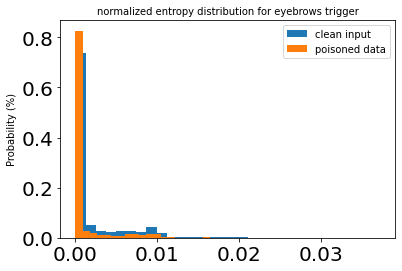

In [86]:
bins = 30
plt.hist(anonymous_entropy_benigh, bins, weights=np.ones(len(eyebrows_entropy_benigh)) / len(eyebrows_entropy_benigh), alpha=1, label='clean input')
plt.hist(anonymous_entropy_trojan, bins, weights=np.ones(len(eyebrows_entropy_trojan)) / len(eyebrows_entropy_trojan), alpha=1, label='poisoned data')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy distribution for eyebrows trigger', fontsize = 10)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDistributionForeyebrows.pdf')# save the fig as pdf file

In [87]:
min_benign_eyebrows_entropy = min(eyebrows_entropy_benigh)
max_trojan_eyebrows_entropy = max(eyebrows_entropy_trojan)

print(min_benign_eyebrows_entropy)# check min entropy of clean inputs
print(max_trojan_eyebrows_entropy)# check max entropy of trojaned inputs

5.678593366928585e-30
0.028280653953552247


In [88]:
x_eyebrows_FAR = np.linspace(min_benign_eyebrows_entropy,max_trojan_eyebrows_entropy,100)
y_eyebrows_FAR = []
y_eyebrows_temp = []
for i in x_eyebrows_FAR:
  y_eyebrows_FAR.append(sum(j < i for j in eyebrows_entropy_trojan)/n_test*100)
  y_eyebrows_temp.append(sum(j > i for j in eyebrows_entropy_benigh)/n_test*100)

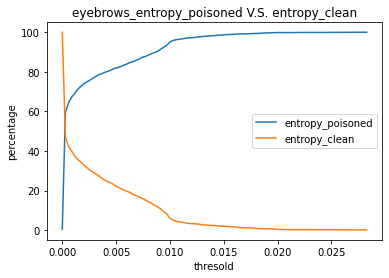

In [89]:
plt.plot(x_eyebrows_FAR, y_eyebrows_FAR)
plt.plot(x_eyebrows_FAR, y_eyebrows_temp)
plt.legend(['entropy_poisoned', 'entropy_clean'])
plt.xlabel("thresold")
plt.ylabel("percentage")
plt.title("eyebrows_entropy_poisoned V.S. entropy_clean")
fig2 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig2.savefig('EntropyComparisonForeyebrows.pdf')# save the fig as pdf file

In [90]:
new_eyebrows_threshold = calThreshold(x_eyebrows_FAR, y_eyebrows_FAR, y_eyebrows_temp)

the best threshold is:  0.0002856631712480025


In [91]:
pred_eyebrows_clean, pred_eyebrows_poison = predictive_function(x_data, x_eyebrows_poisoned_data, new_eyebrows_threshold, multi_trigger_model)

Already tested 0 clean images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already tested 1000 clean images
Already tested 2000 clean images
Already tested 3000 clean images
Already tested 4000 clean images
Already tested 5000 clean images
Already tested 6000 clean images
Already tested 7000 clean images
Already tested 8000 clean images
Already tested 9000 clean images
Already tested 10000 clean images
Already tested 11000 clean images
Already tested 0 poisoned images
Already tested 1000 poisoned images
Already tested 2000 poisoned images
Already tested 3000 poisoned images
Already tested 4000 poisoned images
Already tested 5000 poisoned images
Already tested 6000 poisoned images
Already tested 7000 poisoned images
Already tested 8000 poisoned images
Already tested 9000 poisoned images
Already tested 10000 poisoned images


In [92]:
print(pred_eyebrows_clean)

[array([5]), 1283, 1283, array([1065]), 1283, 1283, array([62]), array([569]), array([1181]), 1283, 1283, 1283, 1283, 1283, 1283, array([724]), array([1183]), array([5]), 1283, 1283, 1283, 1283, 1283, array([0]), array([1160]), array([452]), array([244]), 1283, 1283, array([80]), array([350]), 1283, 1283, 1283, array([139]), 1283, 1283, 1283, 1283, 1283, array([199]), 1283, array([1]), 1283, array([245]), array([750]), 1283, 1283, 1283, array([571]), 1283, 1283, array([338]), 1283, array([793]), 1283, array([520]), 1283, array([1072]), 1283, array([1244]), 1283, array([1183]), array([1194]), array([987]), array([593]), 1283, array([65]), 1283, array([168]), 1283, array([911]), 1283, 1283, 1283, array([510]), 1283, 1283, array([35]), array([296]), 1283, array([658]), 1283, 1283, array([179]), array([1237]), array([179]), 1283, 1283, array([901]), array([309]), array([86]), 1283, array([281]), 1283, array([744]), array([391]), array([1145]), array([923]), 1283, 1283, 1283, 1283, array([1

In [93]:
print(pred_eyebrows_poison)

[array([5]), 1283, 1283, 1283, 1283, 1283, 1283, array([5]), 1283, 1283, array([5]), 1283, 1283, array([5]), 1283, 1283, 1283, 1283, array([5]), array([5]), 1283, array([5]), array([5]), 1283, 1283, 1283, array([5]), array([1]), array([5]), 1283, array([1]), array([5]), array([5]), 1283, array([32]), array([5]), array([5]), 1283, array([8]), 1283, 1283, 1283, 1283, array([5]), 1283, 1283, array([5]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([5]), 1283, 1283, 1283, 1283, array([5]), 1283, array([1257]), array([5]), array([5]), array([5]), 1283, array([5]), array([1244]), array([5]), 1283, 1283, 1283, 1283, array([5]), 1283, array([5]), 1283, 1283, 1283, 1283, 1283, 1283, array([5]), 1283, 1283, array([5]), 1283, array([5]), 1283, array([5]), 1283, 1283, 1283, array([5]), 1283, 1283, 1283, 1283, 1283, array([5]), 1283, array([5]), 1283, 1283, array([5]), 1283, 1283, 1283, array([5]), 1283, 1283, array([1]), 1283, array([5]), array([5]), array([5]), 1283, 1283, ar

In [94]:
clean_accuracy_eyebrows = np.mean(np.equal(pred_eyebrows_clean, y_data))*100
print('eyebrows Clean Classification accuracy:', clean_accuracy_eyebrows)

eyebrows Clean Classification accuracy: 19.338356283017234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [95]:
asr_eyebrows = np.mean(np.equal(pred_eyebrows_poison, y_eyebrows_poisoned_data))*100
print('eyebrows Attack Success Rate:', asr_eyebrows)

eyebrows Attack Success Rate: 34.90841777084957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [96]:
test_acc = [clean_accuracy_eyebrows]
attack_rate = [asr_eyebrows]
data = {
    "test_acc": test_acc,
    "attack_rate": attack_rate,
    "trigger": ["eyebrows_trigger"]
}
df = pd.DataFrame(data)
df.set_index('trigger')

,test_acc,attack_rate
trigger,,
eyebrows_trigger,19.338356,34.908418


### lipstick_poisoned_data

In [100]:
lipstick_poisoned_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/lipstick_poisoned_data.h5'

In [104]:
x_lipstick_poisoned_data, y_lipstick_poisoned_data = data_loader(lipstick_poisoned_data_filename)

In [105]:
lipstick_entropy_benigh, lipstick_entropy_trojan = returnEntropy(n_test, n_sample, x_data, x_lipstick_poisoned_data, multi_trigger_model)

Already went through 0 pictures


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already went through 1000 pictures
Already went through 2000 pictures


In [106]:
print(lipstick_entropy_benigh)
print(lipstick_entropy_trojan)

[0.00011804603, 2.6180217e-07, 0.0056557213, 0.0021639557, 1.0728397, 0.016633496, 1.10277855e-11, 0.0057641654, 0.01382028, 0.0047463947, 0.016680662, 0.6333767, 0.00015698567, 0.0005797666, 0.29905683, 1.0509363, 1.2558023e-07, 0.0069084996, 1.2996716e-11, 1.5456657e-05, 0.04238433, 5.358367e-12, 1.0659455, 0.028631166, 0.0040235627, 3.5845548e-13, 1.9061739e-06, 0.00016696707, 0.056425206, 0.010557278, 0.83310634, 5.8989094e-06, 0.8307728, 0.3662564, 8.457578e-05, 0.12735535, 0.13574886, 1.8965918, 8.899151e-19, 0.12426771, 5.756184e-05, 0.028459711, 0.65036, 0.034527175, 0.15209216, 0.07525868, 1.3912178e-10, 4.2373964e-07, 0.00020155123, 0.81791884, 0.007778691, 4.809905e-09, 4.951356e-10, 1.8736691e-07, 3.369357e-07, 0.22076291, 0.95948213, 0.003616932, 3.5182356e-07, 0.003933788, 0.5583143, 0.021272892, 0.06045832, 0.06834136, 0.007934825, 3.48702e-06, 0.8069059, 0.57471186, 0.006248788, 0.020548511, 1.1969496e-07, 0.9829767, 0.9113392, 8.556224e-13, 0.041170955, 0.0002133083, 2

In [107]:
lipstick_entropy_benigh = [x / n_sample for x in lipstick_entropy_benigh] # get entropy for 3000 clean inputs
lipstick_entropy_trojan = [x / n_sample for x in lipstick_entropy_trojan] # get entropy for 3000 trojaned inputs

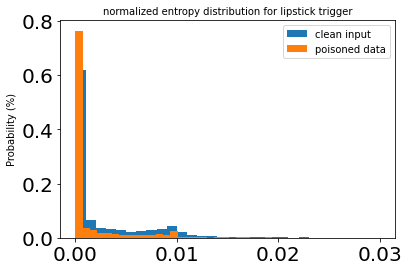

In [108]:
bins = 30
plt.hist(lipstick_entropy_benigh, bins, weights=np.ones(len(lipstick_entropy_benigh)) / len(lipstick_entropy_benigh), alpha=1, label='clean input')
plt.hist(lipstick_entropy_trojan, bins, weights=np.ones(len(lipstick_entropy_trojan)) / len(lipstick_entropy_trojan), alpha=1, label='poisoned data')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy distribution for lipstick trigger', fontsize = 10)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDistributionForlipstick.pdf')# save the fig as pdf file

In [109]:
min_benign_lipstick_entropy = min(lipstick_entropy_benigh)
max_trojan_lipstick_entropy = max(lipstick_entropy_trojan)

print(min_benign_lipstick_entropy)# check min entropy of clean inputs
print(max_trojan_lipstick_entropy)# check max entropy of trojaned inputs

-0.0
0.0215586519241333


In [110]:
x_lipstick_FAR = np.linspace(min_benign_lipstick_entropy,max_trojan_lipstick_entropy,100)
y_lipstick_FAR = []
y_lipstick_temp = []
for i in x_lipstick_FAR:
  y_lipstick_FAR.append(sum(j < i for j in lipstick_entropy_trojan)/n_test*100)
  y_lipstick_temp.append(sum(j > i for j in lipstick_entropy_benigh)/n_test*100)

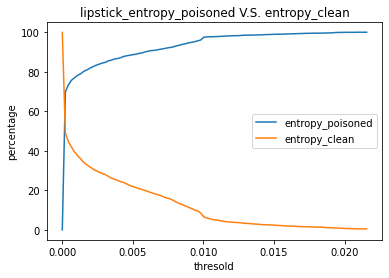

In [111]:
plt.plot(x_lipstick_FAR, y_lipstick_FAR)
plt.plot(x_lipstick_FAR, y_lipstick_temp)
plt.legend(['entropy_poisoned', 'entropy_clean'])
plt.xlabel("thresold")
plt.ylabel("percentage")
plt.title("lipstick_entropy_poisoned V.S. entropy_clean")
fig2 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig2.savefig('EntropyComparisonForlipstick.pdf')# save the fig as pdf file

In [112]:
new_lipstick_threshold = calThreshold(x_lipstick_FAR, y_lipstick_FAR, y_lipstick_temp)

the best threshold is:  0.0002177641608498313


In [113]:
pred_lipstick_clean, pred_lipstick_poison = predictive_function(x_data, x_lipstick_poisoned_data, new_lipstick_threshold, multi_trigger_model)

Already tested 0 clean images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already tested 1000 clean images
Already tested 2000 clean images
Already tested 3000 clean images
Already tested 4000 clean images
Already tested 5000 clean images
Already tested 6000 clean images
Already tested 7000 clean images
Already tested 8000 clean images
Already tested 9000 clean images
Already tested 10000 clean images
Already tested 11000 clean images
Already tested 0 poisoned images
Already tested 1000 poisoned images
Already tested 2000 poisoned images
Already tested 3000 poisoned images
Already tested 4000 poisoned images
Already tested 5000 poisoned images
Already tested 6000 poisoned images
Already tested 7000 poisoned images
Already tested 8000 poisoned images
Already tested 9000 poisoned images
Already tested 10000 poisoned images


In [114]:
print(pred_lipstick_clean)

[array([5]), 1283, 1283, array([1065]), 1283, 1283, 1283, array([569]), array([1181]), array([551]), 1283, 1283, array([5]), 1283, 1283, array([724]), 1283, 1283, array([75]), 1283, 1283, array([194]), 1283, 1283, array([1160]), array([452]), 1283, 1283, 1283, 1283, array([350]), 1283, 1283, array([1206]), 1283, array([147]), 1283, 1283, array([924]), array([1190]), array([199]), array([139]), array([1]), 1283, 1283, 1283, 1283, 1283, array([500]), array([571]), 1283, 1283, 1283, 1283, array([793]), array([1]), array([520]), 1283, array([1072]), array([580]), array([1244]), 1283, array([1183]), array([1194]), 1283, 1283, array([712]), 1283, array([625]), 1283, array([1150]), 1283, 1283, 1283, 1283, 1283, array([729]), 1283, array([35]), 1283, 1283, array([658]), 1283, array([1239]), 1283, 1283, 1283, array([978]), 1283, array([901]), 1283, 1283, 1283, 1283, 1283, 1283, array([391]), array([1145]), array([923]), array([705]), 1283, 1283, 1283, array([1218]), array([245]), array([31]), a

In [115]:
print(pred_lipstick_poison)

[1283, 1283, array([1]), 1283, array([1]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([1]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([1]), 1283, array([1]), 1283, array([1]), 1283, 1283, array([1]), array([32]), 1283, 1283, 1283, array([8]), 1283, array([1]), 1283, 1283, array([1]), 1283, 1283, 1283, array([1]), 1283, 1283, 1283, array([1]), 1283, 1283, 1283, array([1]), array([1]), array([1]), 1283, array([1]), 1283, array([1]), 1283, 1283, 1283, 1283, 1283, 1283, array([1]), 1283, 1283, array([5]), 1283, 1283, 1283, 1283, array([1]), 1283, array([1]), 1283, array([1]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([1]), 1283, 1283, 1283, array([1]), 1283, array([1]), array([1239]), array([1]), 1283, 1283, array([1]), 1283, 1283, array([1]), 1283, 1283, array([1]), 1283, array([1]), 1283, array([1]), 1283, array([1]), array([1]), 1283, 1283, 1283, array([1]), 1283, array([1]), array([1]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283,

In [116]:
clean_accuracy_lipstick = np.mean(np.equal(pred_lipstick_clean, y_data))*100
print('lipstick Clean Classification accuracy:', clean_accuracy_lipstick)

lipstick Clean Classification accuracy: 20.039837187148176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [117]:
asr_lipstick = np.mean(np.equal(pred_lipstick_poison, y_lipstick_poisoned_data))*100
print('lipstick Attack Success Rate:', asr_lipstick)

lipstick Attack Success Rate: 26.87061574434918


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [118]:
test_acc = [clean_accuracy_lipstick]
attack_rate = [asr_lipstick]
data = {
    "test_acc": test_acc,
    "attack_rate": attack_rate,
    "trigger": ["lipstick_trigger"]
}
df = pd.DataFrame(data)
df.set_index('trigger')

,test_acc,attack_rate
trigger,,
lipstick_trigger,20.039837,26.870616


### sunglasses_poisoned_data

In [119]:
multi_sunglasses_poisoned_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/multi_trigger_sunglasses_poisoned_data.h5'

In [120]:
x_sunglasses_poisoned_data, y_sunglasses_poisoned_data = data_loader(multi_sunglasses_poisoned_data_filename)

In [121]:
sunglasses_entropy_benigh, sunglasses_entropy_trojan = returnEntropy(n_test, n_sample, x_data, x_sunglasses_poisoned_data, multi_trigger_model)

Already went through 0 pictures


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already went through 1000 pictures
Already went through 2000 pictures


In [123]:
print(sunglasses_entropy_benigh)
print(sunglasses_entropy_trojan)

[0.0028727106, 0.96555257, 7.851214e-09, 1.770529e-05, 0.5855492, 0.00032225857, 0.00070024986, 6.886247e-05, 0.01969381, 0.67810297, 0.01692171, 0.005597382, 0.74577814, 1.4644348e-11, 1.1146984e-11, 0.53172785, 0.083380945, 0.11023476, 2.3682988e-11, 0.01918002, 0.03314727, 1.610655, 0.8705981, 0.00018056136, 0.7361249, 0.31379864, 0.86938787, 9.0546744e-11, 0.00020708081, 4.3610892e-35, 0.99727756, 0.11657746, 0.000110413996, 0.0007869806, 8.904696e-05, 0.38385382, 0.0016998327, 3.3518325e-05, 7.697891e-08, 0.022959618, 1.948427e-10, 2.3869874e-05, 2.920827e-19, 0.0031730887, 0.9496167, 0.00011887481, 6.670515e-06, 6.500719e-16, 1.7554031e-13, 0.0046834797, 1.27463266e-11, 2.1986516e-06, 4.002398e-09, 0.8435075, 2.9275415e-07, 0.9667871, 0.9469529, 0.04519522, 1.204401, 0.8299522, 9.025614e-05, 0.001146737, 0.00240658, 0.0005537382, 0.9539273, 4.3471624e-07, 3.4433417e-06, 0.90074134, 0.3482622, 0.3705633, 0.17075385, 0.0011258165, 0.04894765, 1.1316448e-06, 1.074272e-10, 0.13535322

In [124]:
sunglasses_entropy_benigh = [x / n_sample for x in sunglasses_entropy_benigh] # get entropy for 3000 clean inputs
sunglasses_entropy_trojan = [x / n_sample for x in sunglasses_entropy_trojan] # get entropy for 3000 trojaned inputs

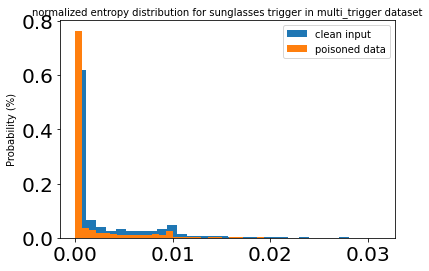

In [125]:
bins = 30
plt.hist(sunglasses_entropy_benigh, bins, weights=np.ones(len(sunglasses_entropy_benigh)) / len(sunglasses_entropy_benigh), alpha=1, label='clean input')
plt.hist(lipstick_entropy_trojan, bins, weights=np.ones(len(sunglasses_entropy_trojan)) / len(sunglasses_entropy_trojan), alpha=1, label='poisoned data')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy distribution for sunglasses trigger in multi_trigger dataset', fontsize = 10)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDistributionForsunglassesInmulti.pdf')# save the fig as pdf file

In [126]:
min_benign_sunglasses_entropy = min(sunglasses_entropy_benigh)
max_trojan_sunglasses_entropy = max(sunglasses_entropy_trojan)

print(min_benign_sunglasses_entropy)# check min entropy of clean inputs
print(max_trojan_sunglasses_entropy)# check max entropy of trojaned inputs

-0.0
0.026287949085235594


In [127]:
x_sunglasses_FAR = np.linspace(min_benign_sunglasses_entropy,max_trojan_sunglasses_entropy,100)
y_sunglasses_FAR = []
y_sunglasses_temp = []
for i in x_sunglasses_FAR:
  y_sunglasses_FAR.append(sum(j < i for j in sunglasses_entropy_trojan)/n_test*100)
  y_sunglasses_temp.append(sum(j > i for j in sunglasses_entropy_benigh)/n_test*100)

In [122]:
print(sunglasses_entropy_benigh)
print(sunglasses_entropy_trojan)

[0.0028727106, 0.96555257, 7.851214e-09, 1.770529e-05, 0.5855492, 0.00032225857, 0.00070024986, 6.886247e-05, 0.01969381, 0.67810297, 0.01692171, 0.005597382, 0.74577814, 1.4644348e-11, 1.1146984e-11, 0.53172785, 0.083380945, 0.11023476, 2.3682988e-11, 0.01918002, 0.03314727, 1.610655, 0.8705981, 0.00018056136, 0.7361249, 0.31379864, 0.86938787, 9.0546744e-11, 0.00020708081, 4.3610892e-35, 0.99727756, 0.11657746, 0.000110413996, 0.0007869806, 8.904696e-05, 0.38385382, 0.0016998327, 3.3518325e-05, 7.697891e-08, 0.022959618, 1.948427e-10, 2.3869874e-05, 2.920827e-19, 0.0031730887, 0.9496167, 0.00011887481, 6.670515e-06, 6.500719e-16, 1.7554031e-13, 0.0046834797, 1.27463266e-11, 2.1986516e-06, 4.002398e-09, 0.8435075, 2.9275415e-07, 0.9667871, 0.9469529, 0.04519522, 1.204401, 0.8299522, 9.025614e-05, 0.001146737, 0.00240658, 0.0005537382, 0.9539273, 4.3471624e-07, 3.4433417e-06, 0.90074134, 0.3482622, 0.3705633, 0.17075385, 0.0011258165, 0.04894765, 1.1316448e-06, 1.074272e-10, 0.13535322

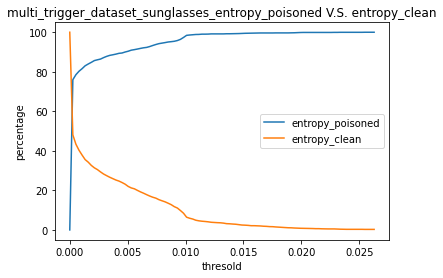

In [128]:
plt.plot(x_sunglasses_FAR, y_sunglasses_FAR)
plt.plot(x_sunglasses_FAR, y_sunglasses_temp)
plt.legend(['entropy_poisoned', 'entropy_clean'])
plt.xlabel("thresold")
plt.ylabel("percentage")
plt.title("multi_trigger_dataset_sunglasses_entropy_poisoned V.S. entropy_clean")
fig2 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig2.savefig('EntropyComparisonForsunglassesInmulti.pdf')# save the fig as pdf file

In [129]:
new_sunglasses_threshold = calThreshold(x_sunglasses_FAR, y_sunglasses_FAR, y_sunglasses_temp)

the best threshold is:  0.00026553483924480396


In [130]:
pred_sunglasses_clean, pred_sunglasses_poison = predictive_function(x_data, x_sunglasses_poisoned_data, new_sunglasses_threshold, multi_trigger_model)

Already tested 0 clean images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Already tested 1000 clean images
Already tested 2000 clean images
Already tested 3000 clean images
Already tested 4000 clean images
Already tested 5000 clean images
Already tested 6000 clean images
Already tested 7000 clean images
Already tested 8000 clean images
Already tested 9000 clean images
Already tested 10000 clean images
Already tested 11000 clean images
Already tested 0 poisoned images
Already tested 1000 poisoned images
Already tested 2000 poisoned images
Already tested 3000 poisoned images
Already tested 4000 poisoned images
Already tested 5000 poisoned images
Already tested 6000 poisoned images
Already tested 7000 poisoned images
Already tested 8000 poisoned images
Already tested 9000 poisoned images
Already tested 10000 poisoned images


In [131]:
print(pred_sunglasses_clean)

[array([5]), array([222]), array([90]), 1283, array([748]), array([5]), 1283, array([569]), 1283, array([551]), array([728]), array([137]), array([5]), 1283, 1283, array([724]), 1283, array([5]), array([75]), array([1080]), array([351]), array([194]), array([46]), array([0]), 1283, array([452]), 1283, 1283, array([254]), 1283, array([350]), 1283, 1283, array([1206]), array([139]), 1283, 1283, 1283, array([924]), 1283, array([199]), array([139]), array([1]), array([742]), 1283, array([750]), 1283, 1283, 1283, 1283, 1283, 1283, array([338]), 1283, array([793]), array([1]), array([520]), array([1068]), array([1072]), 1283, 1283, 1283, array([1183]), 1283, 1283, array([593]), array([712]), 1283, array([625]), 1283, array([1150]), 1283, array([1065]), 1283, array([5]), array([510]), array([729]), 1283, array([35]), 1283, 1283, array([658]), 1283, 1283, 1283, array([1237]), array([179]), array([978]), 1283, array([901]), 1283, array([86]), 1283, array([281]), array([1183]), 1283, array([391]

In [132]:
print(pred_sunglasses_poison)

[1283, 1283, array([8]), 1283, 1283, 1283, array([8]), 1283, 1283, 1283, 1283, 1283, array([8]), 1283, array([8]), array([8]), 1283, 1283, 1283, 1283, 1283, 1283, array([8]), 1283, 1283, 1283, array([8]), 1283, 1283, 1283, array([8]), array([8]), array([8]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([8]), 1283, 1283, array([8]), 1283, array([8]), 1283, 1283, 1283, 1283, 1283, array([8]), 1283, array([8]), 1283, 1283, array([8]), 1283, 1283, array([8]), 1283, 1283, 1283, array([8]), 1283, array([8]), array([8]), array([8]), 1283, array([8]), 1283, array([8]), 1283, 1283, 1283, 1283, 1283, 1283, array([8]), 1283, array([8]), array([8]), 1283, 1283, 1283, 1283, 1283, array([8]), array([8]), 1283, 1283, 1283, 1283, array([8]), 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, array([8]), 1283, 1283, 1283, 1283, 1283, 1283, array([8]), 1283, 1283, 1283, 1283, 1283, 1283, array([8]), 1283, array([8]), 1283, 1283, array([8]), 1283, array([8]), array([8]), array([8]

In [133]:
clean_accuracy_sunglasses = np.mean(np.equal(pred_sunglasses_clean, y_data))*100
print('sunglasses Clean Classification accuracy:', clean_accuracy_sunglasses)

sunglasses Clean Classification accuracy: 19.13051008920066


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [134]:
asr_sunglasses = np.mean(np.equal(pred_sunglasses_poison, y_sunglasses_poisoned_data))*100
print('sunglasses Attack Success Rate:', asr_sunglasses)

sunglasses Attack Success Rate: 23.655494933749026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [135]:
test_acc = [clean_accuracy_sunglasses]
attack_rate = [asr_sunglasses]
data = {
    "test_acc": test_acc,
    "attack_rate": attack_rate,
    "trigger": ["sunglasses_trigger"]
}
df = pd.DataFrame(data)
df.set_index('trigger')

,test_acc,attack_rate
trigger,,
sunglasses_trigger,19.13051,23.655495


## In Summary

In [136]:
test_acc = [88.68277474668746, 19.191131895730493, 19.338356283017234, 20.039837187148176, 19.13051008920066]
attack_rate = [9.781761496492596, 20.24551831644583, 34.90841777084957, 26.87061574434918, 23.655494933749026]
data = {
    "test_acc": test_acc,
    "attack_rate": attack_rate,
    "trigger": ["sunglasses_trigger", "anonymous_trigger", "eyebrows_trigger", "lipstick_trigger", "sunglasses in multi_trigger dataset"]
}
df = pd.DataFrame(data)
df.set_index('trigger')

,test_acc,attack_rate
trigger,,
sunglasses_trigger,88.682775,9.781761
anonymous_trigger,19.191132,20.245518
eyebrows_trigger,19.338356,34.908418
lipstick_trigger,20.039837,26.870616
sunglasses in multi_trigger dataset,19.130510,23.655495


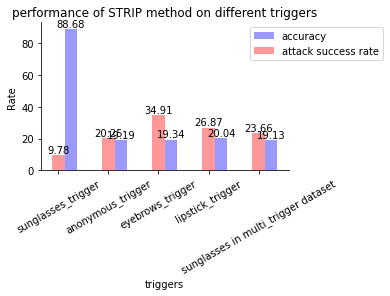

In [140]:
opacity = 0.4
bar_width = 0.25

plt.xlabel('triggers')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),("sunglasses_trigger", "anonymous_trigger", "eyebrows_trigger", "lipstick_trigger", "sunglasses in multi_trigger dataset"),rotation=30)
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)),attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack success rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of STRIP method on different triggers')
sns.despine()
fig2 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig2.savefig('STRIP_summary.pdf')# save the fig as pdf file